# MRI Dimentia Classification - Model Generator using VGG-16
VGG-16 is an existing Convolutional Neural Network (CNN) proposed by the Visual Geometry Group (VGG) at the University of Oxford consisting of 16 layers, including convolutional, pooling, and fully connected layers. For details of this model go to: https://www.geeksforgeeks.org/vgg-16-cnn-model/

This model is used for MRI classification of dementia with 4 known stages (Non-Demented, Mild Demented, Moderate Demented and Very Mild Demented). Severe onset dementia is known as Alzheimer's Disease which will not be covered in this analysis. 

In [2]:
# Import Dependencies and Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Here we're leveraging a function called ImageDataGenerator() from the Tensor library to combine all of the operations of rescaling, setting our target size, batch size, etc to prep them into respective bins - Train, Test and Validation. 

In [ ]:
# Resize all input images to 224x224
image_size = (224, 224)

# Number of images the model processes before updating weights
batch_size = 32

# Set local data paths
train_dir = 'dataset/train'
val_dir = 'dataset/val'
test_dir = 'dataset/test'


# Store ImageDataGenerator parameters in a dictionary
imageDataGenerator_params = {
    'rescale': 1./255
}

In [ ]:
# Image Generators 

# Rescaling [0,1] for neural networks to process normalized values
train_datagen = ImageDataGenerator(imageDataGenerator_params)
val_datagen = ImageDataGenerator(imageDataGenerator_params)
test_datagen = ImageDataGenerator(imageDataGenerator_params)

# Create Generators for Train, Val and Test
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 11350 images belonging to 4 classes.
Found 960 images belonging to 4 classes.
Found 960 images belonging to 4 classes.


In [8]:
# Build a Transfer Learning Model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze base

# Build the custom classifier
model = Sequential([
    base_model,
    GlobalAveragePooling2D(), # Reduces output to 1D vector
    Dense(256, activation='relu'), # Fully connected layer with ReLU
    Dense(512, activation='relu'), # 2nd connected layer with ReLU
    Dropout(0.5), # Randomly turn off 50% of neurons to prevent overfitting
    Dense(4, activation='softmax')  # Final output layer for 4 classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [5]:
# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,979,652 (57.14 MB)

 Trainable params: 264,964 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
%%time
# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10


/opt/anaconda3/envs/dev/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


355/355 ━━━━━━━━━━━━━━━━━━━━ 1770s 5s/step - accuracy: 0.3210 - loss: 1.4246 - val_accuracy: 0.1406 - val_loss: 1.4806
Epoch 2/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 1688s 5s/step - accuracy: 0.4551 - loss: 1.1837 - val_accuracy: 0.3604 - val_loss: 1.3489
Epoch 3/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 1673s 5s/step - accuracy: 0.5366 - loss: 1.0702 - val_accuracy: 0.4313 - val_loss: 1.2475
Epoch 4/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 1669s 5s/step - accuracy: 0.5839 - loss: 0.9798 - val_accuracy: 0.4510 - val_loss: 1.1703
Epoch 5/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 1668s 5s/step - accuracy: 0.6139 - loss: 0.9114 - val_accuracy: 0.4698 - val_loss: 1.1190
Epoch 6/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 1648s 5s/step - accuracy: 0.6490 - loss: 0.8502 - val_accuracy: 0.4802 - val_loss: 1.0905
Epoch 7/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 1653s 5s/step - accuracy: 0.6593 - loss: 0.8148 - val_accuracy: 0.5042 - val_loss: 1.0335
Epoch 8/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 1670s 5s/step - accuracy: 0.6845 - loss: 0.7655 - val_accurac

In [ ]:
# Save the model into an .keras file
model.save("saved_models/dementia_model_VGG16_V2.keras")

In [ ]:
# Load model from .keras file
model = load_model("saved_models/dementia_model_VGG16_V2.keras")

30/30 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.6455 - loss: 0.9224
Test Accuracy: 0.51
30/30 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step


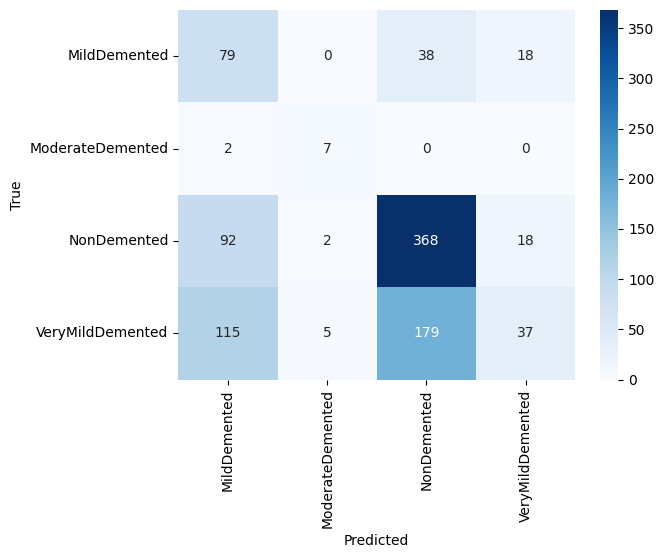

              precision    recall  f1-score   support

           0       0.27      0.59      0.37       135
           1       0.50      0.78      0.61         9
           2       0.63      0.77      0.69       480
           3       0.51      0.11      0.18       336

    accuracy                           0.51       960
   macro avg       0.48      0.56      0.46       960
weighted avg       0.54      0.51      0.47       960

CPU times: user 28min 36s, sys: 37 s, total: 29min 13s
Wall time: 4min 20s


In [25]:
%%time
# Evaluation on Test Set
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2f}")

# Predictions and Confusion Matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_true, y_pred_classes))

In [10]:
# Create a varible to store the final name of the model
filename = model.name
filename

'sequential_2'